In [1]:
import tensorflow as tf

import numpy as np
import time
import functools

from PIL import Image

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import matplotlib.pyplot as plt

In [2]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3: # if tensor includes batch size
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg',
                                       origin='https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

style_path = tf.keras.utils.get_file('kandinsky5.jpg',
                                     origin='https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## Visualize the input

In [4]:
def load_image(path_to_image):
    max_dim = 512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    
    # scale the longer dim to max_dim, and another dim scale with identical factor
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] # add batch dimension
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

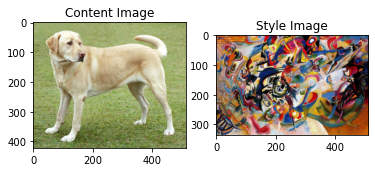

In [6]:
content_image = load_image(content_path)
style_image = load_image(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the TensorFlow Hub module does:

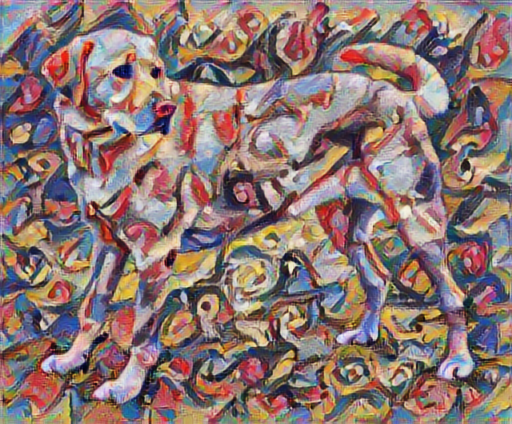

In [7]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, you are using the `VGG19` network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.

In [8]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [9]:
predicted_top5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy(), top=5)[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top5]

[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665294),
 ('kuvasz', 0.03635755),
 ('Chesapeake_Bay_retriever', 0.024182769),
 ('Greater_Swiss_Mountain_dog', 0.018646086)]

Now load a `vgg19` without the classification head, and list the layer names

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose the intermediate layers from the network to represent the style and content of the image:

In [11]:
content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model

In [12]:
def vgg_layers(layer_names):
    """Create a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(layer).output for layer in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print('  min: ', output.numpy().min())
    print('  max: ', output.numpy().max())
    print('  mean: ', output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24
  mean:  230.78104

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.2401

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.254
  mean:  59.179478



In [14]:
print('{} {}'.format(content_layers[0], vgg_layers(content_layers).outputs))

block5_conv2 [<tf.Tensor 'block5_conv2_3/Identity:0' shape=(None, None, None, 512) dtype=float32>]


## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the `means` and `correlations` `across the different feature maps`. Calculate a Gram matrix that includes this information by taking the `outer product` of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$
G_{c d}^{l}=\frac{\sum_{i j} F_{i j c}^{l}(x) F_{i j d}^{l}(x)}{I J}
$$

$F_{ijc}^l$, $i$ and $j$ is _img_height_ and _img_weight_ (pixel location) dimension, $c$ or $d$ is _channel_ dimension. $l$ is `layer` dimension.

So, these two 3-D tensors should have identical number of img_height and img_width.

In [15]:
def gram_matrix(input_tensor):
    """Calcualte Gram matrix.
    There are only on input tensor, so it is calculating:
    For each pixel position, there are `C` channels/feature maps, out product to 
      create `C * C` matrix M, M[i,j] means channel_i * channel_j.
    Then, sum up across all pixels/positions.
    
    Args:
        input_tensor: of shape [BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNEL], float32/float64
    Returns:
        tensor with shape [BATCH_SIZE, CHANNEL, CHANNEL]
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32) # img_height * img_width
    return result / (num_locations)

In [16]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers, **kwargs):
        super(StyleContentModel, self).__init__(**kwargs)
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        """EXpect [0, 1] float inputs"""
        inputs = inputs * 255.0
        preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_inputs)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # Gram Matrix
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value in
                        zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value
                      for style_name, value in
                      zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228453
    max:  28014.555
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.4
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.5
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.38
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.879
    mean:  13.764149


## Run gradient descent

In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [19]:
# Define a `tf.variable` to contain the image to optimize.
image = tf.Variable(content_image)

In [20]:
# Since this is a float image, define a function to keep the pixel value [0, 1]
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [22]:
style_weight = 1e-2
content_weight = 1e4

In [23]:
def style_content_loss(outputs):
    """Calculate style and content losses."""
    # style loss part
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([
        # element-wise MSE for each style layer
        tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers # average on each layer and multiple by style weight
    
    # content loss part
    content_loss = tf.add_n([
        # element-wise MSE for each content layer
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers
    
    # total loss
    loss = style_loss + content_loss

    return loss

In [24]:
# Use tf.GradientTape to update the image.
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    gradients = tape.gradient(loss, image)
    optimizer.apply_gradients([(gradients, image)])
    image.assign(clip_0_1(image))

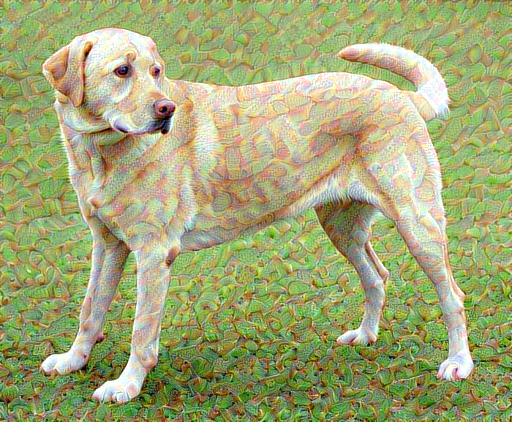

In [25]:
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [26]:
import IPython.display as display

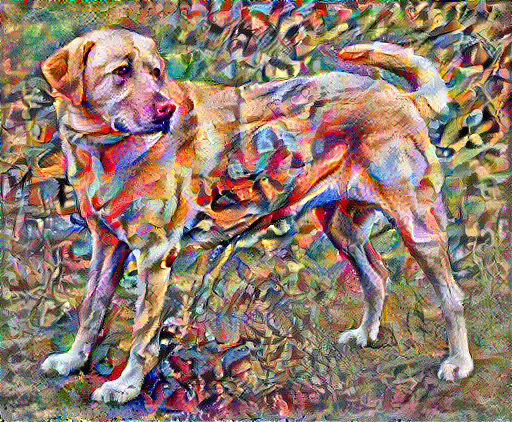

Train step: 1000
Total time: 80.9


In [27]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

In [28]:
def high_pass_x_y(image):
    # [BATCH_SIZE, HEIGHT, WIDTH, CHANNEL]
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :] # calculate x direction gradient
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :] # calculate y direction gradient
    return x_var, y_var

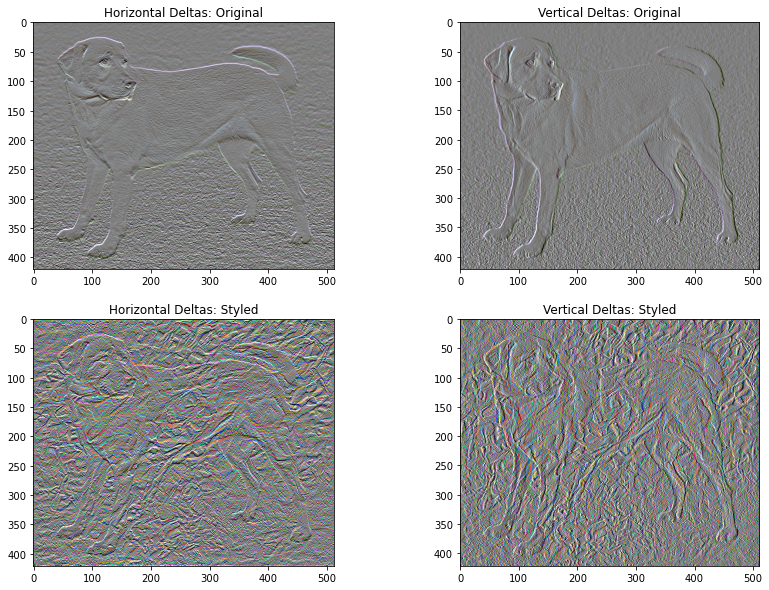

In [29]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased. Also, this high frequency component is basically an edge-detector.

In [30]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [31]:
total_variation_loss(image).numpy()

149381.19

In [32]:
# TF has implement that
tf.image.total_variation(image).numpy()

array([149381.19], dtype=float32)

## Re-tun the optimization

In [33]:
total_variation_weight = 30

In [34]:
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_loss(image) * total_variation_weight
        
    gradients = tape.gradient(loss, image)
    optimizer.apply_gradients([(gradients, image)])
    image.assign(clip_0_1(image))

In [35]:
image = tf.Variable(content_image)

In [36]:
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

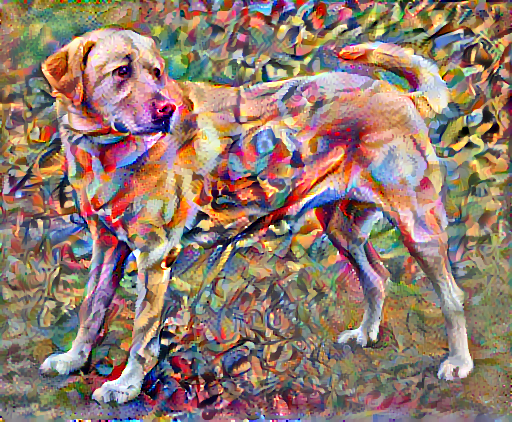

Train step: 1000
Total time: 83.0


In [37]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))